In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function


import tensorflow_hub as hub
from tensorflow.keras.applications.densenet import DenseNet121, preprocess_input
import pandas as pd
import numpy as np
import os

import IPython.display as display

# from PIL import Image

import tensorflow as tf

import tensorflow.keras as keras
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Conv2D, Flatten, GlobalMaxPooling2D, Dropout

from tensorflow.keras.preprocessing import image

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


from datetime import datetime
from packaging import version

from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau



gpus = tf.config.experimental.list_physical_devices("GPU")
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices("GPU")
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
        
        
        
        
def append_extension(fn):
    return (fn+".jpg").zfill(7)


def ordered_logit(class_number):
    # zero portability
    target = np.zeros(4, dtype=int)
    target[:class_number-2] = 1
    return target


DATADIR = r"./adult" 
CSV_PATH = r"./adult/CastControls_ALP.xlsx"
response = pd.read_excel(
    CSV_PATH,
    sheet_name=0,
)[["GreenID", "Grade"]].dropna(axis=0, subset=['Grade'])
response.Grade = response.Grade.astype('int')
response.GreenID = response.GreenID.astype('str').apply(append_extension)
response = response[response.Grade != 99]
response = pd.concat([response, pd.DataFrame.from_dict(dict(response.Grade.apply(ordered_logit))).T], axis=1)



#shuffle dataset
response = response.sample(frac=1)


data_gen = ImageDataGenerator(
    rotation_range=5,
    fill_mode='reflect',
    horizontal_flip=True,
#     vertical_flip=True,
    validation_split=0.1,
    rescale=1. / 255.,
#     preprocessing_function = preprocess_input
    zoom_range = 0.1
)

train_set = data_gen.flow_from_dataframe(
    dataframe=response,
    directory=DATADIR,
    x_col="GreenID",
    target_size=(224,224),
    color_mode='rgb',
    subset = "training",
    shuffle=True,
    
#     class_mode = "sparse"
#     y_col="Grade",
    y_col=[0,1,2,3,],
    class_mode='raw', 
)

validation_set = data_gen.flow_from_dataframe(
    dataframe=response,
    directory=DATADIR,
    x_col="GreenID",
    target_size=(224,224),
    color_mode='rgb',
    subset = "validation",
    shuffle=True,
    batch_size = 28,
    
#     class_mode = "sparse"
#     y_col="Grade",
    y_col=[0,1,2,3,],
    class_mode='raw',
)

train_set.reset()
validation_set.reset()
# print(next(validation_set)[1].shape)        


import tensorflow.keras.backend as K
def soft_acc(y_true, y_pred):
    return K.mean(K.equal(K.round(y_true), K.round(y_pred)))

def soft_acc_multi_output(y_true, y_pred):
    return K.mean(K.all(K.equal(K.cast(K.round(y_true),'int32'), K.cast(K.round(y_pred),'int32')),axis=1))

1 Physical GPUs, 1 Logical GPUs
Found 507 validated image filenames.
Found 56 validated image filenames.


C:\Users\feroc\Anaconda3\envs\tf\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:273: UserWarning: Found 6 invalid image filename(s) in x_col="GreenID". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [2]:
feature_extractor_url = "https://tfhub.dev/google/efficientnet/b0/feature-vector/1" 
# module = hub.Module(feature_extractor_url, tags=['train'])
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(224,224,3),tags={"train"}, trainable=True)
feature_extractor_layer.trainable = False

# it is not possible (yet) to use effnet in tf2.0...

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [3]:
base_model = tf.keras.Sequential([
  feature_extractor_layer,
    Dropout(0.5),
#   Dense(64 ,activation = 'linear'),
#     Dropout(0.2),
    Dense(4 ,activation = 'linear'),
    Dense(4, activation="sigmoid")
],name="effnet")
base_model.compile(optimizer=keras.optimizers.Nadam(), loss='binary_crossentropy', metrics=[soft_acc_multi_output],name="effnet_base")
# we may fine-tune "twice"

In [4]:
# logdir_name = r".\tfb\logs\effnet\\" + base_model.name + datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_callback = TensorBoard(log_dir=logdir_name)
early_stopping = EarlyStopping(monitor='val_loss', patience=14,restore_best_weights=True)
reduce_lr_plateau = ReduceLROnPlateau(monitor='val_loss', patience = 7, factor = 0.8)
history_base_model = base_model.fit_generator(generator=train_set,
                    epochs=50,
#                     verbose=0,
                    validation_data=validation_set,
#                     validation_freq=2,
                    callbacks = [early_stopping,reduce_lr_plateau]
                    )
train_set.reset()
validation_set.reset()

Epoch 1/50
16/16 [==============================] - 10s 630ms/step - loss: 0.6275 - soft_acc_multi_output: 0.1790 - val_loss: 0.5785 - val_soft_acc_multi_output: 0.2679
Epoch 2/50
16/16 [==============================] - 5s 340ms/step - loss: 0.5439 - soft_acc_multi_output: 0.2486 - val_loss: 0.5488 - val_soft_acc_multi_output: 0.2321
Epoch 3/50
16/16 [==============================] - 6s 376ms/step - loss: 0.5064 - soft_acc_multi_output: 0.2971 - val_loss: 0.5166 - val_soft_acc_multi_output: 0.3393
Epoch 4/50
16/16 [==============================] - 6s 373ms/step - loss: 0.4804 - soft_acc_multi_output: 0.3411 - val_loss: 0.5154 - val_soft_acc_multi_output: 0.3393
Epoch 5/50
16/16 [==============================] - 6s 378ms/step - loss: 0.4635 - soft_acc_multi_output: 0.4047 - val_loss: 0.4775 - val_soft_acc_multi_output: 0.4107
Epoch 6/50
16/16 [==============================] - 6s 376ms/step - loss: 0.4453 - soft_acc_multi_output: 0.4113 - val_loss: 0.4744 - val_soft_acc_multi_output

tf.Tensor(0.42857143, shape=(), dtype=float32)


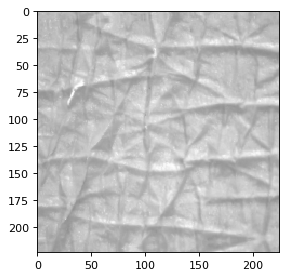

true label: [1 1 1 0]; rounded pred: [0.99374247 0.8003993  0.3579697  0.05287883]; Correct: False


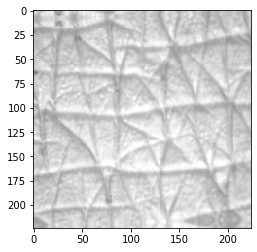

true label: [0 0 0 0]; rounded pred: [0.8874481  0.6420998  0.53800976 0.35922033]; Correct: False


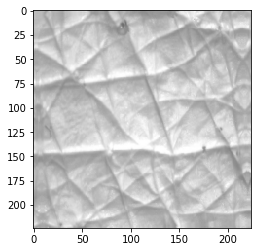

true label: [1 1 0 0]; rounded pred: [0.8961084  0.7279801  0.11201096 0.07872114]; Correct: True


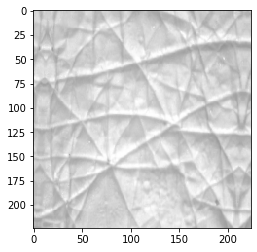

true label: [1 1 0 0]; rounded pred: [0.9452837  0.85210097 0.19676685 0.10573661]; Correct: True


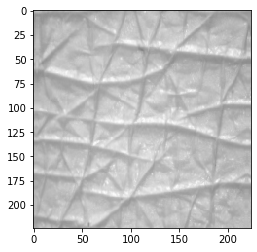

true label: [1 0 0 0]; rounded pred: [0.4862378  0.48289675 0.21288925 0.14081979]; Correct: False


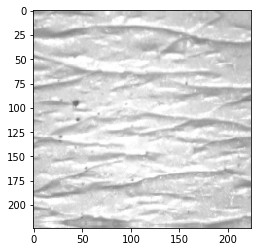

true label: [1 1 1 0]; rounded pred: [0.98785317 0.9369315  0.8430303  0.56088525]; Correct: False


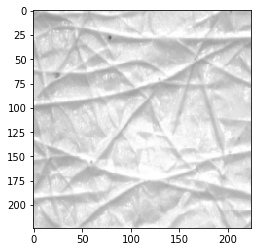

true label: [1 1 1 1]; rounded pred: [0.9555907  0.8106818  0.23452178 0.14019409]; Correct: False


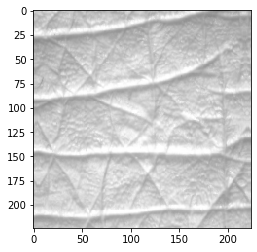

true label: [1 0 0 0]; rounded pred: [0.62778157 0.1995497  0.11291003 0.03358558]; Correct: True


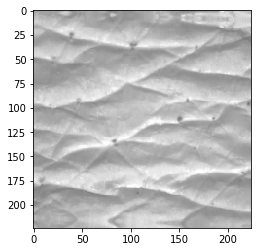

true label: [1 1 0 0]; rounded pred: [0.95705616 0.78749585 0.57763755 0.2314887 ]; Correct: False


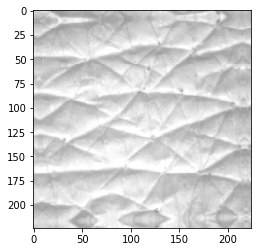

true label: [0 0 0 0]; rounded pred: [0.9841882  0.78076386 0.14414617 0.0148949 ]; Correct: False


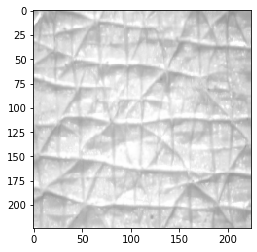

true label: [1 0 0 0]; rounded pred: [0.90862834 0.6698738  0.09743384 0.0492067 ]; Correct: False


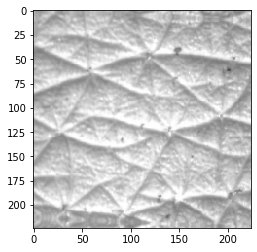

true label: [0 0 0 0]; rounded pred: [0.78294986 0.66057295 0.49986893 0.46818975]; Correct: False


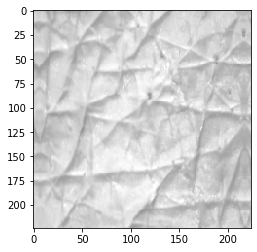

true label: [1 1 0 0]; rounded pred: [0.99855685 0.9649966  0.850806   0.50900793]; Correct: False


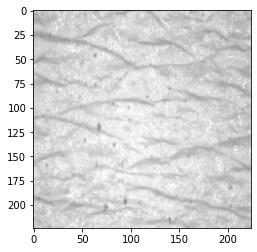

true label: [1 1 1 0]; rounded pred: [0.95604146 0.84331906 0.8130121  0.5561986 ]; Correct: False


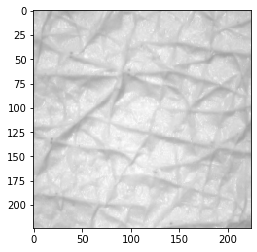

true label: [1 1 0 0]; rounded pred: [0.6603     0.59224015 0.3178344  0.23074394]; Correct: True


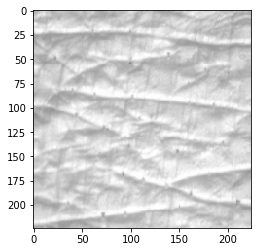

true label: [1 1 1 0]; rounded pred: [0.99912596 0.89696276 0.9303463  0.28876942]; Correct: True


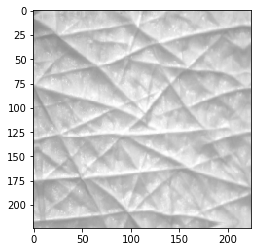

true label: [1 1 0 0]; rounded pred: [0.889987   0.50772434 0.03322062 0.01106659]; Correct: True


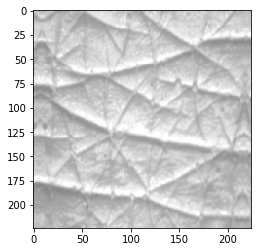

true label: [1 0 0 0]; rounded pred: [0.6661458  0.14906758 0.04795858 0.01004586]; Correct: True


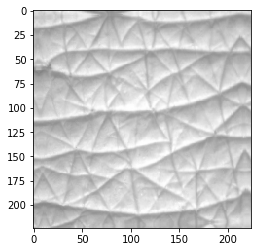

true label: [0 0 0 0]; rounded pred: [0.05759779 0.0570958  0.01993269 0.01591972]; Correct: True


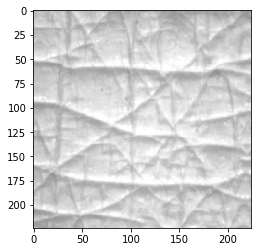

true label: [1 1 0 0]; rounded pred: [0.9290297  0.5844978  0.2951318  0.09146205]; Correct: True


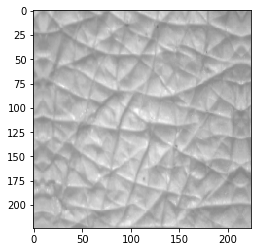

true label: [1 1 0 0]; rounded pred: [0.965415   0.8369483  0.01254931 0.00542796]; Correct: True


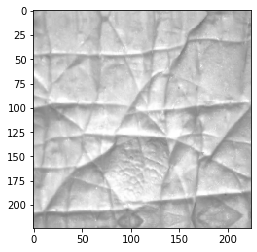

true label: [1 1 0 0]; rounded pred: [0.9999253  0.99563724 0.5497841  0.14491886]; Correct: False


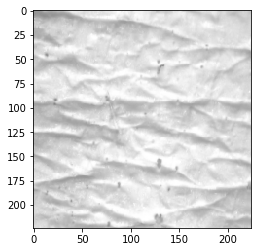

true label: [1 1 1 1]; rounded pred: [0.9977405 0.9401493 0.9461081 0.6303934]; Correct: True


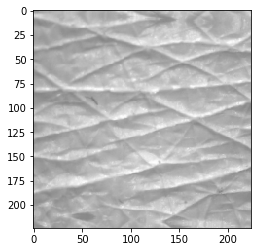

true label: [1 1 1 0]; rounded pred: [0.9925889 0.9417895 0.6021336 0.2412081]; Correct: True


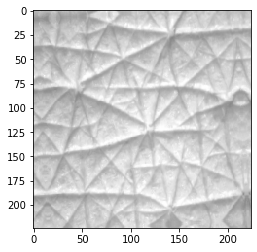

true label: [0 0 0 0]; rounded pred: [0.60200685 0.113058   0.04626846 0.02011663]; Correct: False


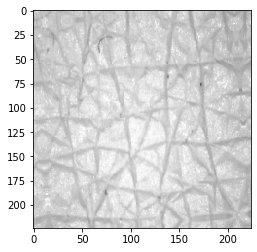

true label: [0 0 0 0]; rounded pred: [0.9183655  0.78709435 0.43249553 0.30318975]; Correct: False


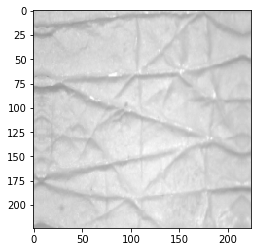

true label: [1 1 0 0]; rounded pred: [0.82714945 0.64830947 0.55212635 0.2691243 ]; Correct: False


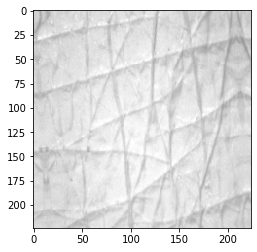

true label: [1 1 0 0]; rounded pred: [0.98542225 0.88830376 0.7724259  0.4995591 ]; Correct: False


In [5]:
fig, ax = plt.subplots(dpi=80)
batch = next(validation_set)

y_true = batch[1]
y_pred = base_model.predict(batch[0])
print(soft_acc_multi_output(y_true,y_pred))

# print examples from the validation set
for i in range(len(batch[1])):
    img = batch[0][i]
    label = batch[1][i]
    assert (label == y_true[i]).all()
    right = K.all(K.equal(K.cast(K.round(label),'int32'), K.cast(K.round(y_pred[i]),'int32')))
    plt.imshow(img)
    plt.show()
    print(f"true label: {label}; rounded pred: {y_pred[i]}; Correct: {right}")
    
    
    
###
# notice that without fine-tuning the 

In [ ]:
#####################################

In [6]:
base_model.trainable = False
x = base_model.output
preds = Dense(4, activation="sigmoid")(x)
model = Model(inputs=base_model.input, outputs=preds, name = "effnet_full")
model.compile(optimizer=keras.optimizers.Nadam(), loss='binary_crossentropy', metrics=[soft_acc_multi_output], name = "effnet_full")

# logdir_name = r".\tfb\logs\effnet\\" + model.name + datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_callback = TensorBoard(log_dir=logdir_name)
early_stopping = EarlyStopping(monitor='val_loss', patience=14,restore_best_weights=True)
reduce_lr_plateau = ReduceLROnPlateau(monitor='val_loss', patience = 7, factor = 0.8)

history_full_model = model.fit_generator(generator=train_set,
                    epochs=75,
#                     verbose=0,
                    validation_data=validation_set,
#                     validation_freq=2,
                    callbacks = [early_stopping,reduce_lr_plateau]
                    )
train_set.reset()
validation_set.reset()

Epoch 1/75
 1/16 [>.............................] - ETA: 6s - loss: 0.9172 - soft_acc_multi_output: 0.0000e+00WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.464756). Check your callbacks.


16/16 [==============================] - 8s 474ms/step - loss: 0.8574 - soft_acc_multi_output: 0.0332 - val_loss: 0.8367 - val_soft_acc_multi_output: 0.0179
Epoch 2/75
16/16 [==============================] - 6s 390ms/step - loss: 0.8263 - soft_acc_multi_output: 0.0433 - val_loss: 0.8374 - val_soft_acc_multi_output: 0.0000e+00
Epoch 3/75
16/16 [==============================] - 6s 396ms/step - loss: 0.8127 - soft_acc_multi_output: 0.0414 - val_loss: 0.8313 - val_soft_acc_multi_output: 0.0000e+00
Epoch 4/75
16/16 [==============================] - 6s 395ms/step - loss: 0.7867 - soft_acc_multi_output: 0.0620 - val_loss: 0.7740 - val_soft_acc_multi_output: 0.0179
Epoch 5/75
16/16 [==============================] - 6s 394ms/step - loss: 0.7773 - soft_acc_multi_output: 0.0663 - val_loss: 0.7910 - val_soft_acc_multi_output: 0.0000e+00
Epoch 6/75
16/16 [==============================] - 6s 394ms/step - loss: 0.7549 - soft_acc_multi_output: 0.0694 - val_loss: 0.7634 - val_soft_acc_multi_output

In [ ]:
####################################

In [7]:
model.trainable=True
model.compile(optimizer=keras.optimizers.Nadam(), loss='binary_crossentropy', metrics=[soft_acc_multi_output], name = "effnet_ft")
logdir_name = r".\tfb\logs\effnet\\" + model.name + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=logdir_name)
early_stopping = EarlyStopping(monitor='val_loss', patience=21,restore_best_weights=True)
reduce_lr_plateau = ReduceLROnPlateau(monitor='val_loss', patience = 7, factor = 0.5)

history_full_model = model.fit_generator(generator=train_set,
                    epochs=75,
#                     verbose=0,
                    validation_data=validation_set,
#                     validation_freq=2,
                    callbacks = [tensorboard_callback,early_stopping, reduce_lr_plateau]
                    )
train_set.reset()
validation_set.reset()

Epoch 1/75
 1/16 [>.............................] - ETA: 6s - loss: 0.4346 - soft_acc_multi_output: 0.4375WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.640040). Check your callbacks.


16/16 [==============================] - 8s 501ms/step - loss: 0.4334 - soft_acc_multi_output: 0.3907 - val_loss: 0.3968 - val_soft_acc_multi_output: 0.4286
Epoch 2/75
16/16 [==============================] - 6s 392ms/step - loss: 0.4167 - soft_acc_multi_output: 0.4282 - val_loss: 0.3934 - val_soft_acc_multi_output: 0.3214
Epoch 3/75
16/16 [==============================] - 6s 386ms/step - loss: 0.4052 - soft_acc_multi_output: 0.4240 - val_loss: 0.4025 - val_soft_acc_multi_output: 0.3214
Epoch 4/75
16/16 [==============================] - 6s 396ms/step - loss: 0.3956 - soft_acc_multi_output: 0.4067 - val_loss: 0.3842 - val_soft_acc_multi_output: 0.4286
Epoch 5/75
16/16 [==============================] - 6s 394ms/step - loss: 0.3723 - soft_acc_multi_output: 0.4622 - val_loss: 0.3784 - val_soft_acc_multi_output: 0.3393
Epoch 6/75
16/16 [==============================] - 6s 388ms/step - loss: 0.3717 - soft_acc_multi_output: 0.4598 - val_loss: 0.3923 - val_soft_acc_multi_output: 0.3571
Epo

tf.Tensor(0.53571427, shape=(), dtype=float32)


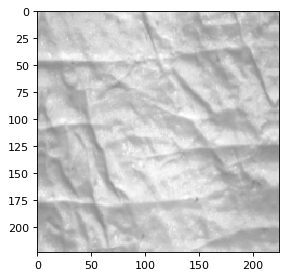

true label: [1 1 1 1]; rounded pred: [[0.94612914 0.73503214 0.27856156 0.1086697 ]]; Correct: False


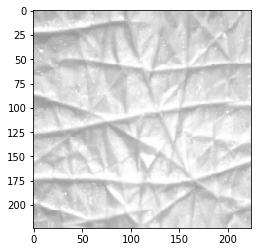

true label: [1 1 0 0]; rounded pred: [[0.9310335  0.682722   0.21805641 0.09450215]]; Correct: True


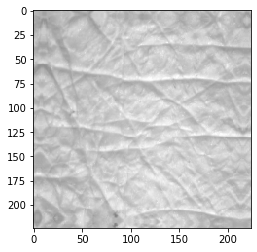

true label: [1 1 1 0]; rounded pred: [[0.93703735 0.72077286 0.27239317 0.12713051]]; Correct: False


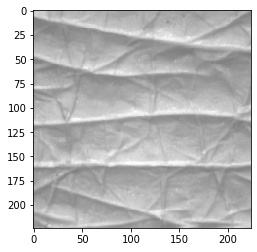

true label: [1 1 0 0]; rounded pred: [[0.9523908  0.73674643 0.2691413  0.11931866]]; Correct: True


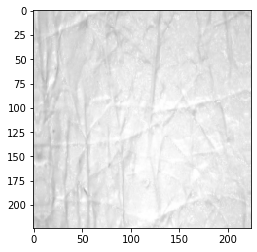

true label: [1 1 1 1]; rounded pred: [[0.9488764  0.71545774 0.2375682  0.08441737]]; Correct: True


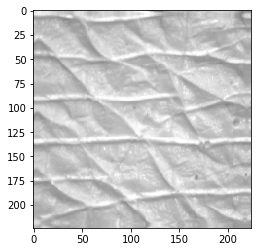

true label: [1 1 1 0]; rounded pred: [[0.950256   0.72921145 0.25862873 0.09630531]]; Correct: True


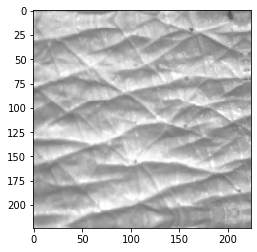

true label: [1 1 1 0]; rounded pred: [[0.9488589  0.752388   0.30685624 0.12581795]]; Correct: False


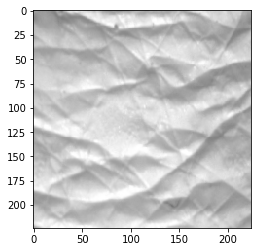

true label: [1 1 1 1]; rounded pred: [[0.95061684 0.7520303  0.3121742  0.12824234]]; Correct: False


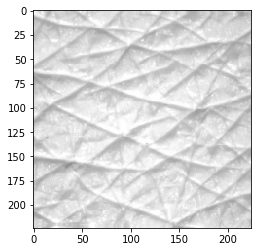

true label: [1 0 0 0]; rounded pred: [[0.9424094  0.723656   0.2715154  0.12161529]]; Correct: True


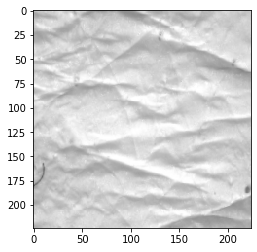

true label: [1 1 1 1]; rounded pred: [[0.9543264  0.7379062  0.26108956 0.09142911]]; Correct: True


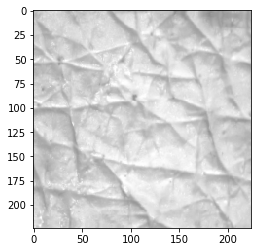

true label: [1 1 0 0]; rounded pred: [[0.94640213 0.71690035 0.24502754 0.10735834]]; Correct: False


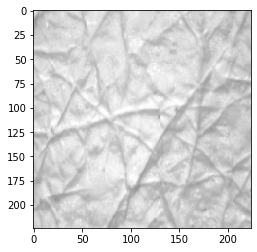

true label: [1 1 1 1]; rounded pred: [[0.92909384 0.6805455  0.20688504 0.08056605]]; Correct: True


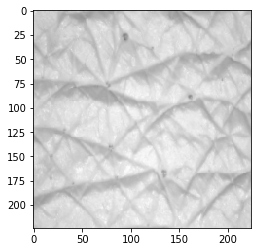

true label: [1 1 0 0]; rounded pred: [[0.96021616 0.77122426 0.32122713 0.12567082]]; Correct: False


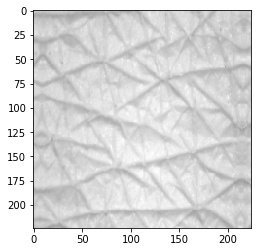

true label: [0 0 0 0]; rounded pred: [[0.9531889 0.7256907 0.2491279 0.1010164]]; Correct: True


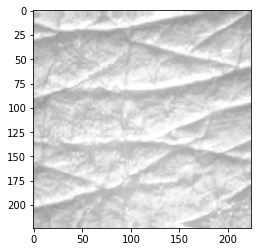

true label: [1 0 0 0]; rounded pred: [[0.94711    0.7267359  0.2565482  0.09579036]]; Correct: False


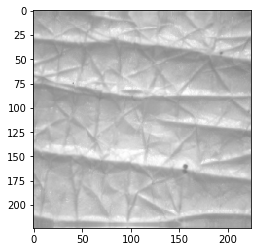

true label: [1 0 0 0]; rounded pred: [[0.9426724  0.72450364 0.26696366 0.09808236]]; Correct: True


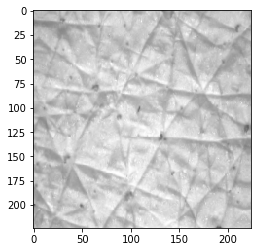

true label: [1 1 1 0]; rounded pred: [[0.94864094 0.733645   0.26725954 0.10363451]]; Correct: False


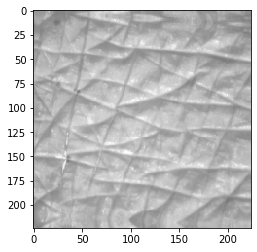

true label: [1 1 0 0]; rounded pred: [[0.9644649  0.762353   0.28773272 0.11015946]]; Correct: True


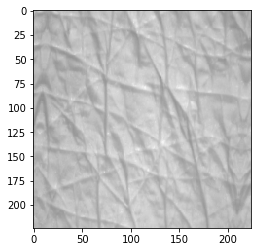

true label: [1 1 1 0]; rounded pred: [[0.9461038  0.7227056  0.25309464 0.102516  ]]; Correct: False


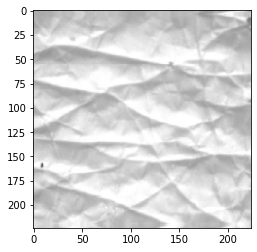

true label: [1 1 0 0]; rounded pred: [[0.93647575 0.7011151  0.23578215 0.0915468 ]]; Correct: True


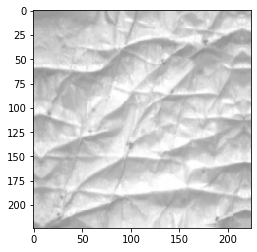

true label: [1 1 1 1]; rounded pred: [[0.948672   0.7464348  0.28753585 0.10734409]]; Correct: False


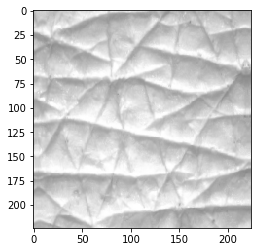

true label: [1 0 0 0]; rounded pred: [[0.9535074  0.749117   0.28049612 0.11967054]]; Correct: False


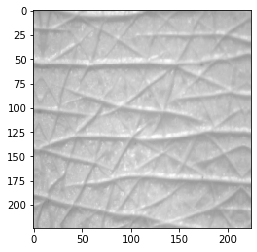

true label: [0 0 0 0]; rounded pred: [[0.94034606 0.6979769  0.23347566 0.09570286]]; Correct: False


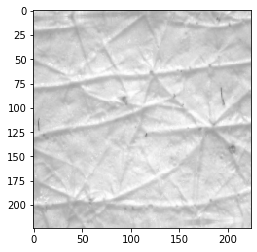

true label: [1 1 1 0]; rounded pred: [[0.9400089  0.71199614 0.25065553 0.11251965]]; Correct: True


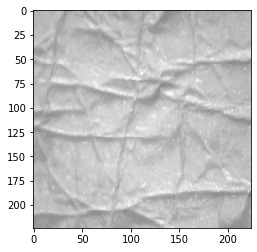

true label: [1 1 1 0]; rounded pred: [[0.95444846 0.7611829  0.31679475 0.12846848]]; Correct: False


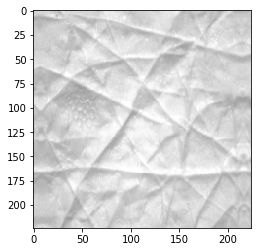

true label: [1 1 0 0]; rounded pred: [[0.95649207 0.75864494 0.29854044 0.11527613]]; Correct: True


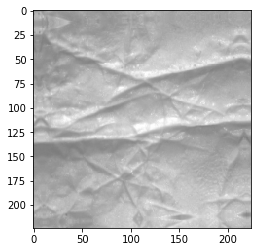

true label: [1 1 1 1]; rounded pred: [[0.9367828  0.699372   0.22795653 0.07461414]]; Correct: True


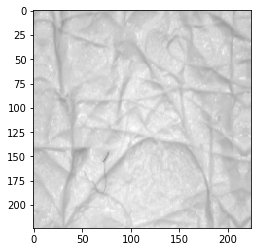

true label: [1 1 0 0]; rounded pred: [[0.9152348  0.65279424 0.20326978 0.0848192 ]]; Correct: True


In [10]:
fig, ax = plt.subplots(dpi=80)
batch = next(validation_set)

y_true = batch[1]
y_pred = model.predict(batch[0])
print(soft_acc_multi_output(y_true,y_pred))

# print examples from the validation set
for i in range(len(batch[1])):
    img = batch[0][i]
    label = batch[1][i]
    right = K.all(K.equal(K.cast(K.round(label),'int32'), K.cast(K.round(y_pred[i]),'int32')))
    plt.imshow(img)
    plt.show()
    print(f"true label: {label}; rounded pred: {model.predict(img.reshape(-1,224, 224, 3))}; Correct: {right}")

In [ ]:
## fine tuning in 2.0 api is not possible


# for layer in model.layers:
#     layer.trainable = True
# model.compile(optimizer=keras.optimizers.Nadam(learning_rate=0.0002), loss='binary_crossentropy', metrics=[soft_acc_multi_output], name = "effnet_finetune")

# logdir_name = r".\tfb\logs\effnet\\" + model.name + datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_callback = TensorBoard(log_dir=logdir_name)
# early_stopping = EarlyStopping(monitor='val_loss', patience=21,restore_best_weights=True)
# reduce_lr_plateau = ReduceLROnPlateau(monitor='val_loss', patience = 7, factor = 0.8)

# history_fine_tune = model.fit_generator(generator=train_set,
#                     epochs=100 + history_full_model,
# #                     verbose=2,
#                     validation_data=validation_set,
# #                     validation_freq=2,
#                     initial_epoch = history_full_model.epoch[-1]
#                     callbacks = [tensorboard_callback,early_stopping, reduce_lr_plateau]
#                     )